# Analyzing Results for Non-Standardized Data

In [1]:
import pandas as pd
import numpy as np
#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#Statistical Analysis
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare
#import scikit_posthocs as sp
# Import files
import glob

In [2]:
path = "../Results/MinMax/*.csv"
models = []
for fname in glob.glob(path):
    df=pd.read_csv(fname)
    models.append(df)
    my_list=list(df.columns)
    print(len(my_list),my_list)

3 ['folder_name', 'PCA_mm_auc', 'PCA_mm_avgprecision']
3 ['folder_name', 'OCSVM_mm_auc', 'OCSVM_mm_avgprecision']
3 ['folder_name', 'BRM_mm_auc', 'BRM_mm_avgprecision']
3 ['folder_name', 'XGBOD_mm_auc', 'XGBOD_mm_avgprecision']
3 ['folder_name', 'MAX_Bagging_mm_auc', 'MAX_Bagging_mm_avgprecision']
3 ['folder_name', 'Median_KNN_mm_auc', 'Median_KNN_mm_avgprecision']
3 ['folder_name', 'Largest_KNN_mm_auc', 'Largest_KNN_mm_avgprecision']
3 ['folder_name', 'VAE_mm_auc', 'VAE_mm_avgprecision']
3 ['folder_name', 'IQR_LMDD_mm_auc', 'IQR_LMDD_mm_avgprecision']
3 ['folder_name', 'SOD_mm_auc', 'SOD_mm_avgprecision']
3 ['folder_name', 'Avg_KNN_mm_auc', 'Avg_KNN_mm_avgprecision']
3 ['folder_name', 'LSCP_mm_auc', 'LSCP_mm_avgprecision']
3 ['folder_name', 'MCD_mm_auc', 'MCD_mm_avgprecision']
3 ['folder_name', 'CBLOF_mm_auc', 'CBLOF_mm_avgprecision']
3 ['folder_name', 'AAD_LMDD_mm_auc', 'AAD_LMDD_mm_avgprecision']
3 ['folder_name', 'AE_mm_auc', 'AE_mm_avgprecision']
3 ['folder_name', 'HBOS_mm_auc', '

In [3]:
# Separate AUC and Precision 
from functools import reduce
def separate_performance(models):
    join_models = pd.concat(
    (dataframe.set_index('folder_name') for dataframe in models),
    axis=1, join='inner' ).reset_index()
    auc_df = join_models.loc[:, join_models.columns.str.endswith('auc')]
    avg_prec_df = join_models.loc[:, join_models.columns.str.endswith('avgprecision')]
    return join_models, auc_df,avg_prec_df

In [4]:
join_models,df_auc,df_avg_precision  = separate_performance(models)

In [5]:
models_names = df_auc.columns.tolist()
models_names_auc = [i.rstrip('_mm_auc') for i in models_names]
models_names2 = df_avg_precision.columns.tolist()
models_names_avg = [i.rstrip('_mm_averageprecision') for i in models_names2]

In [6]:
dataset_names = join_models['folder_name']

In [7]:
# Plot Performance Metrics
def plot_metrics(df, title = 'Classifiers AUC Evaluation', y_label = 'AUC', list_names =[]):
    plt.figure(figsize=(25, 20))
    box = plt.boxplot(df,
                patch_artist=True, # to fill with color
                notch='True', # notch shape
                labels=list_names) # the labels to use
    plt.title(title, fontsize=25)
    plt.ylabel(y_label, fontsize=20)
    plt.xticks(rotation=90, fontsize = 15)
    plt.yticks(fontsize = 15)
    # fill with different colors
    colors = ['blue', 'orchid','peru', 'green', 'teal','wheat','red', 'indigo', 'brown', 'pink',
                'grey','magenta','limegreen','lightsteelblue','royalblue','navy','slateblue','aquamarine','tan','lightcoral',
                'salmon','khaki','darkslategray','lawngreen','purple','azure','darkseagreen','rosybrown','orange']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    return plt.show()

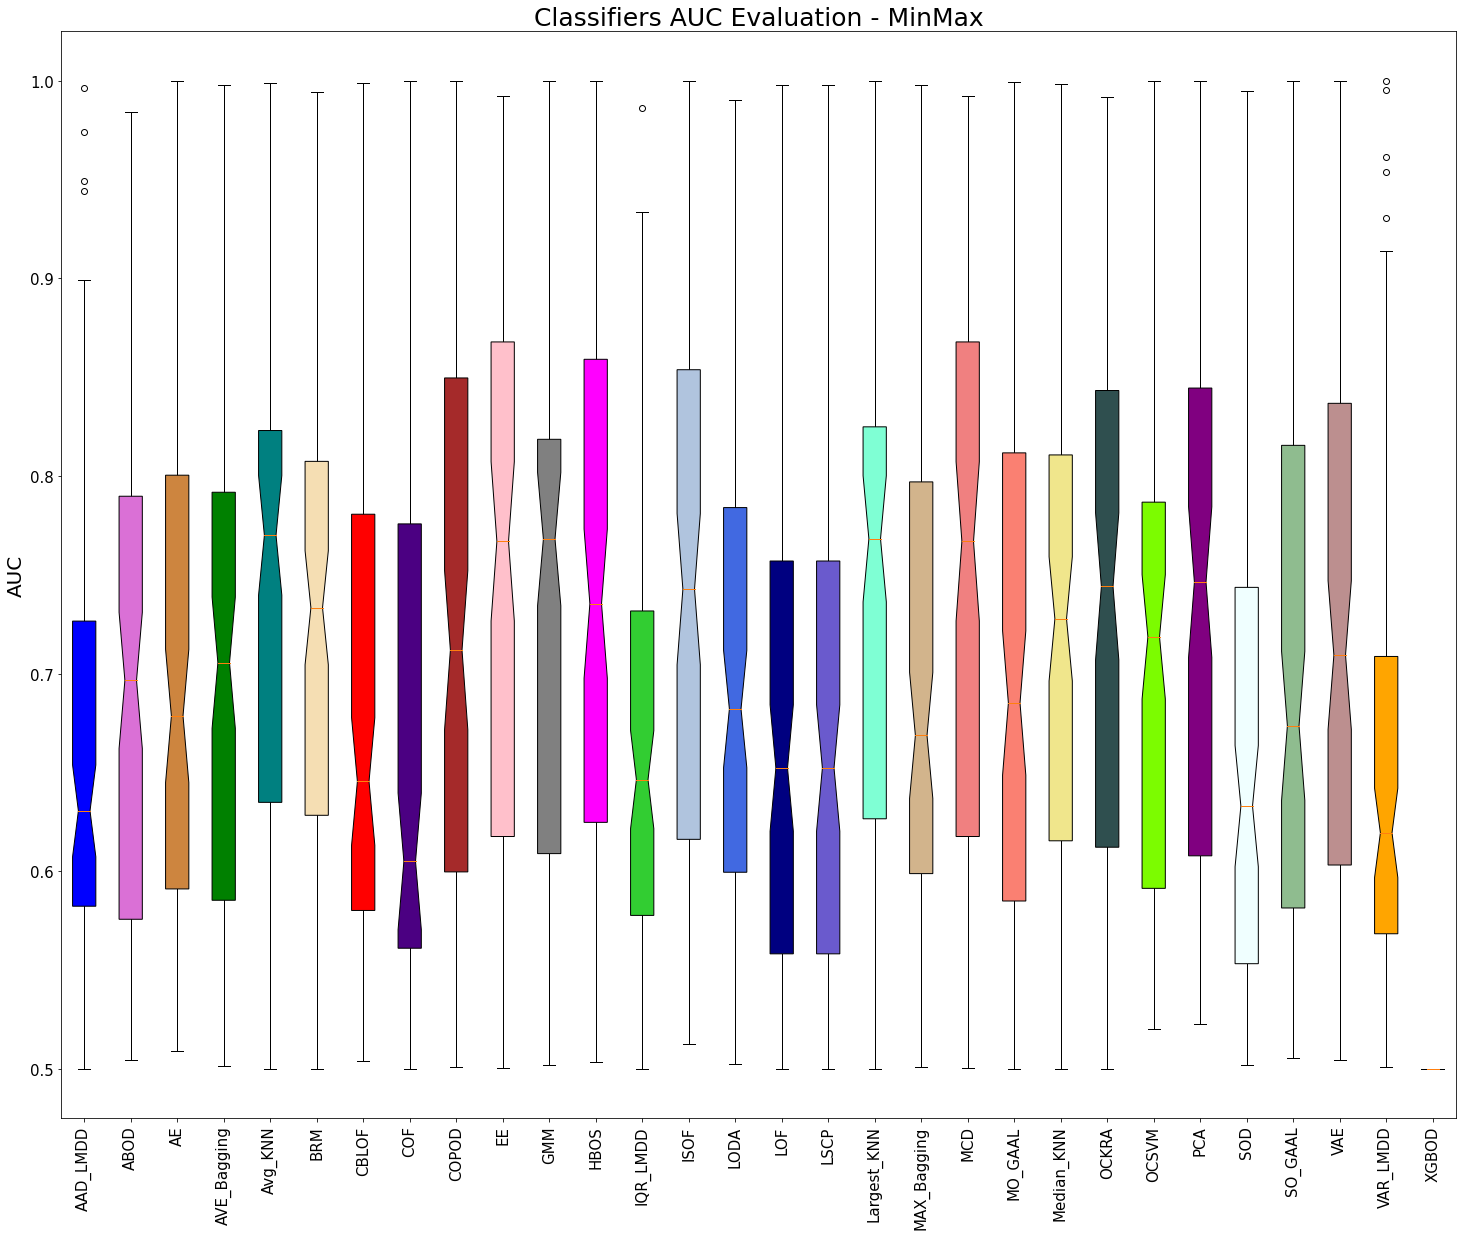

In [8]:
df_auc2 = df_auc.reindex(sorted(df_auc.columns), axis=1)
plot_metrics(df_auc2,title = 'Classifiers AUC Evaluation - MinMax', y_label = 'AUC', list_names =[i.rstrip('_mm_auc') for i in df_auc2.columns.tolist()])

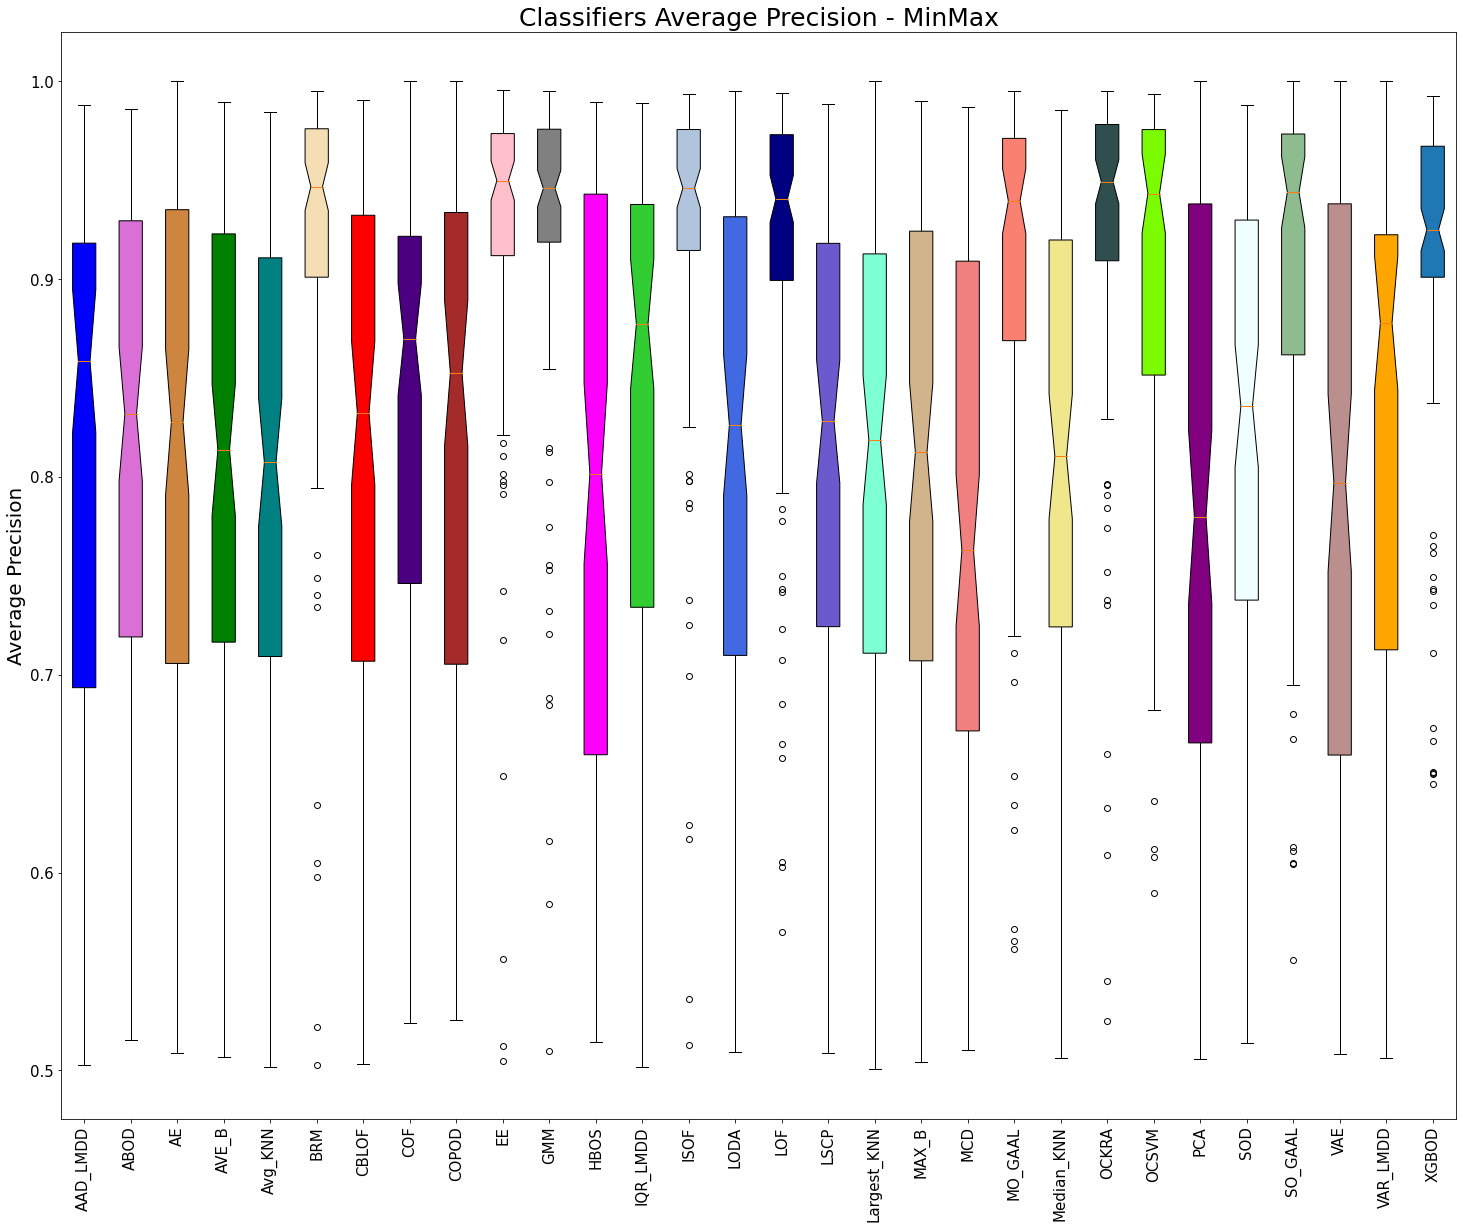

In [9]:
df_avg_precision2 = df_avg_precision.reindex(sorted(df_avg_precision.columns), axis=1)
plot_metrics(df_avg_precision2 , 'Classifiers Average Precision - MinMax' , 'Average Precision' , list_names =[i.rstrip('_mm_avgprecision') for i in df_avg_precision2.columns.tolist()])


In [10]:
mean_auc = df_auc.mean()
mean_avg = df_avg_precision.mean()
# Save the object in a python file
import pickle
with open('mm_mean_auc.data','wb') as data:
    pickle.dump(mean_auc, data)
with open('mm_mean_avg.data','wb') as data:
    pickle.dump(mean_avg, data)

# Hypothesis Testing

Comparing multiple classifiers over multiple datasets

In [10]:
#pip install Orange3
#pip install scipy
#pip install autorank

In [11]:
from scipy.stats import friedmanchisquare , rankdata
from Orange.evaluation import compute_CD, graph_ranks
from autorank import autorank, plot_stats, create_report, latex_table

In [12]:
# dataset names
df_auc['dataset_names'] = dataset_names
df_avg_precision['dataset_names'] = dataset_names
# algorithms names
algorithms_names_auc =df_auc.drop('dataset_names', axis=1).columns
algorithms_names_avg =df_avg_precision.drop('dataset_names', axis=1).columns

In [13]:
performances_array = df_auc[algorithms_names_auc].values
# Finally, we apply the Friedman test.
friedmanchisquare(*performances_array)

FriedmanchisquareResult(statistic=1379.4217091598716, pvalue=2.14005549049823e-227)

In [14]:
def friedman_test(*args):
    stat, p = friedmanchisquare(*args)
    print('Statistics=%.3f, p=%.4E' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        return 'Fail to reject H0'
    else:
	    return 'Reject H0'

In [15]:
# For AUC
*a, = [df_auc.iloc[:,i] for i in range(len(df_auc.drop('dataset_names', axis=1).columns))]
a_np = np.array(a) # Here the columns correspond to the blocking factor (datasets) and the rows to the algorithms
a_np = a_np.T # Here the rows correspond to the blocking factor (datasets) and the columns correspond to the primary factor (algorithms)
friedman_test(*a_np)

Statistics=1379.422, p=2.1401E-227


'Reject H0'

In [16]:
# For Average Precision
*b, = [df_avg_precision.iloc[:,i] for i in range(len(df_avg_precision.drop('dataset_names', axis=1).columns))]
b_np = np.array(b) # Here the columns correspond to the blocking factor (datasets) and the rows to the algorithms
b_np = b_np.T # Here the rows correspond to the blocking factor (datasets) and the columns correspond to the primary factor (algorithms)
friedman_test(*b_np)

Statistics=1689.178, p=1.2854E-290


'Reject H0'

## Rankings 

In [17]:
ranks_auc = np.array([rankdata(-p) for p in a_np])
ranks_avg_precision = np.array([rankdata(-p) for p in b_np])

In [18]:
ranks_auc_df = pd.DataFrame(ranks_auc, columns = algorithms_names_auc)

In [19]:
ranks_avg_precision_df = pd.DataFrame(ranks_avg_precision, columns = algorithms_names_avg)

In [20]:
# Calculating the average ranks.
average_ranks_auc = np.average(ranks_auc, axis=0)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names_auc, average_ranks_auc)))

PCA_mm_auc average rank: 12.08421052631579
OCSVM_mm_auc average rank: 15.163157894736843
BRM_mm_auc average rank: 12.994736842105263
XGBOD_mm_auc average rank: 29.910526315789475
MAX_Bagging_mm_auc average rank: 16.45263157894737
Median_KNN_mm_auc average rank: 13.226315789473684
Largest_KNN_mm_auc average rank: 11.905263157894737
VAE_mm_auc average rank: 13.2
IQR_LMDD_mm_auc average rank: 18.673684210526314
SOD_mm_auc average rank: 19.81578947368421
Avg_KNN_mm_auc average rank: 11.4
LSCP_mm_auc average rank: 17.721052631578946
MCD_mm_auc average rank: 10.947368421052632
CBLOF_mm_auc average rank: 17.36315789473684
AAD_LMDD_mm_auc average rank: 17.894736842105264
AE_mm_auc average rank: 15.578947368421053
HBOS_mm_auc average rank: 12.973684210526315
OCKRA_mm_auc average rank: 12.357894736842105
VAR_LMDD_mm_auc average rank: 18.073684210526316
COF_mm_auc average rank: 20.042105263157893
GMM_mm_auc average rank: 12.98421052631579
COPOD_mm_auc average rank: 13.473684210526315
AVE_Bagging_

In [21]:
result_auc = autorank(df_auc.drop('dataset_names',axis = 1), alpha=0.05, verbose=False)
print(result_auc)

RankResult(rankdf=
                     meanrank    median        mad  ci_lower  ci_upper  \
EE_mm_auc           10.931579  0.766938   0.177699  0.628648  0.863778   
MCD_mm_auc          10.947368  0.766938   0.177699  0.628648  0.863778   
Avg_KNN_mm_auc      11.400000      0.77   0.138554  0.639862  0.821557   
Largest_KNN_mm_auc  11.905263  0.768235   0.135093  0.643996  0.824176   
ISOF_mm_auc         11.978947  0.742757   0.174818  0.625719  0.852462   
PCA_mm_auc          12.084211   0.74633    0.17931  0.627227  0.840511   
OCKRA_mm_auc        12.357895  0.744138   0.169578  0.625973  0.842595   
HBOS_mm_auc         12.973684  0.735417   0.182113   0.63066   0.85825   
GMM_mm_auc          12.984211  0.768098   0.165676  0.614728   0.81617   
BRM_mm_auc          12.994737  0.733349   0.135448  0.632781  0.806831   
VAE_mm_auc          13.200000  0.709398   0.167879   0.61339  0.833993   
Median_KNN_mm_auc   13.226316  0.727713   0.138004  0.641754  0.807122   
COPOD_mm_auc       

In [22]:
create_report(result_auc)
#latex_table(result_auc)

The statistical analysis was conducted for 30 populations with 95 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations EE_mm_auc (p=0.001), MCD_mm_auc (p=0.001), HBOS_mm_auc (p=0.001), GMM_mm_auc (p=0.001), BRM_mm_auc (p=0.000), Median_KNN_mm_auc (p=0.000), COPOD_mm_auc (p=0.002), OCSVM_mm_auc (p=0.000), MO_GAAL_mm_auc (p=0.000), LODA_mm_auc (p=0.000), AVE_Bagging_mm_auc (p=0.000), MAX_Bagging_mm_auc (p=0.000), LOF_mm_auc (p=0.001), ABOD_mm_auc (p=0.002), IQR_LMDD_mm_auc (p=0.000), SOD_mm_auc (p=0.000), COF_mm_auc (p=0.000), and XGBOD_mm_auc (p=0.002). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nem

In [23]:
#algorithms_names_auc = [i.rstrip('_mm_auc') for i in algorithms_names_auc]
#algorithms_names_avg = [i.rstrip('_mm_avg_precision') for i in algorithms_names_avg]

In [24]:
df_ranking_avg_auc = pd.DataFrame(average_ranks_auc, index = algorithms_names_auc)
df_ranking_avg_auc.columns = ['auc']

In [25]:
# Calculating the average ranks.
average_ranks_avg_precision = np.average(ranks_avg_precision, axis=0)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names_avg, average_ranks_avg_precision)))

PCA_mm_avgprecision average rank: 19.205263157894738
OCSVM_mm_avgprecision average rank: 10.6
BRM_mm_avgprecision average rank: 8.063157894736841
XGBOD_mm_avgprecision average rank: 10.926315789473684
MAX_Bagging_mm_avgprecision average rank: 18.763157894736842
Median_KNN_mm_avgprecision average rank: 20.28421052631579
Largest_KNN_mm_avgprecision average rank: 20.71578947368421
VAE_mm_avgprecision average rank: 19.226315789473684
IQR_LMDD_mm_avgprecision average rank: 17.50526315789474
SOD_mm_avgprecision average rank: 17.53684210526316
Avg_KNN_mm_avgprecision average rank: 20.63684210526316
LSCP_mm_avgprecision average rank: 19.03684210526316
MCD_mm_avgprecision average rank: 20.942105263157895
CBLOF_mm_avgprecision average rank: 19.31578947368421
AAD_LMDD_mm_avgprecision average rank: 18.54736842105263
AE_mm_avgprecision average rank: 17.55263157894737
HBOS_mm_avgprecision average rank: 18.28421052631579
OCKRA_mm_avgprecision average rank: 7.657894736842105
VAR_LMDD_mm_avgprecision a

In [26]:
df_ranking_avg_avgprecision = pd.DataFrame(average_ranks_avg_precision, index = algorithms_names_avg)
df_ranking_avg_avgprecision.columns = ['average_precision']

In [27]:
result_avg = autorank(df_avg_precision.drop('dataset_names',axis = 1), alpha=0.05, verbose=False)
print(result_avg)

RankResult(rankdf=
                              meanrank    median        mad  ci_lower  \
EE_mm_avgprecision            6.768421    0.9497   0.038328  0.921168   
GMM_mm_avgprecision           7.121053  0.945715  0.0433932  0.920141   
OCKRA_mm_avgprecision         7.657895  0.949097  0.0477468   0.91598   
ISOF_mm_avgprecision          7.957895  0.945884  0.0447673  0.919056   
BRM_mm_avgprecision           8.063158  0.946639  0.0474633   0.90448   
LOF_mm_avgprecision          10.036842  0.940419  0.0528451  0.903236   
MO_GAAL_mm_avgprecision      10.105263  0.939325  0.0543148  0.889889   
OCSVM_mm_avgprecision        10.600000  0.943157  0.0515846  0.867621   
SO_GAAL_mm_avgprecision      10.642105  0.943806  0.0568968  0.878436   
XGBOD_mm_avgprecision        10.926316  0.924855  0.0556402  0.901163   
COF_mm_avgprecision          17.231579  0.869405   0.109378  0.761848   
COPOD_mm_avgprecision        17.284211  0.852464   0.133928  0.715404   
IQR_LMDD_mm_avgprecision     17.

In [28]:
create_report(result_avg)
#latex_table(result_avg)

The statistical analysis was conducted for 30 populations with 95 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations EE_mm_avgprecision (p=0.000), GMM_mm_avgprecision (p=0.000), OCKRA_mm_avgprecision (p=0.000), ISOF_mm_avgprecision (p=0.000), BRM_mm_avgprecision (p=0.001), LOF_mm_avgprecision (p=0.000), MO_GAAL_mm_avgprecision (p=0.000), OCSVM_mm_avgprecision (p=0.000), SO_GAAL_mm_avgprecision (p=0.000), XGBOD_mm_avgprecision (p=0.000), COF_mm_avgprecision (p=0.000), COPOD_mm_avgprecision (p=0.000), IQR_LMDD_mm_avgprecision (p=0.000), SOD_mm_avgprecision (p=0.000), AE_mm_avgprecision (p=0.000), LODA_mm_avgprecision (p=0.000), ABOD_mm_avgprecision (p=0.000), HBOS_mm_avgprecision (p=0.000), VAR_LMDD_mm_avgprecision (p=0.000), AAD_LMDD_mm_avgprecision (p=0.000), MAX_Bagging_mm_avgprecision (p=0.000), LSCP_mm_avgprecision (p=0.000), AVE_Bagging_mm_avgprecision (p=0.000), PCA_mm_av

In [29]:
df_ranking_avg_auc = pd.DataFrame(average_ranks_auc, index = algorithms_names_auc)
df_ranking_avg_auc.columns = ['auc']
df_ranking_avg_avgprecision = pd.DataFrame(average_ranks_avg_precision, index = algorithms_names_avg)
df_ranking_avg_avgprecision.columns = ['average_precision']

In [34]:
import scikit_posthocs as sp

In [35]:
blocks = sp.__convert_to_block_df(a_np)
blocks

(      blocks groups         y
 0          0      0  0.596597
 1          1      0  0.560967
 2          2      0  0.613390
 3          3      0  0.832829
 4          4      0  1.000000
 ...      ...    ...       ...
 2845      90     29  0.568578
 2846      91     29  0.650863
 2847      92     29  0.757544
 2848      93     29  0.682776
 2849      94     29  0.802083
 
 [2850 rows x 3 columns],
 'y',
 'groups',
 'blocks')

## Post-Hoc Evaluation

In [39]:
# Post-hoc analysis

from scikit_posthocs import posthoc_nemenyi_friedman as nemenyi
import scipy as sp
import scipy.stats as st
import itertools as it
import sys
sys.path.append('/Volumes/GoogleDrive/My Drive/MCCNotes/Jlab projects/GITHUB_repositories/Clones/stac/stac/')
# Or you could import the module as a whole,
#from nonparametric_tests import shaffer_multitest,friedman_test,nemenyi_multitest

In [40]:
ev_auc = df_auc.drop('dataset_names',axis = 1).copy()
ev_avg = df_avg_precision.drop('dataset_names', axis = 1).copy()
ev_auc.columns = [i.rstrip('_mm_auc') for i in ev_auc.columns]
ev_avg.columns = [i.rstrip('_mm_avgprecision') for i in ev_avg.columns ]

In [41]:
ny_auc = nemenyi(ev_auc)

Text(0.5, 1.0, 'AUC Signifcant Difference with Nemenyi - MinMax')

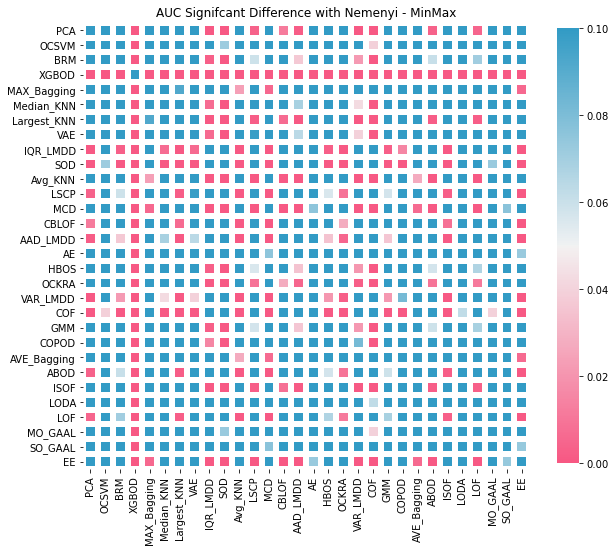

In [42]:
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
ax = sns.heatmap(ny_auc, annot=False, fmt=".1f", 
           linewidths=5, cmap=cmap, vmin=0, vmax=0.1, 
           cbar_kws={"shrink": .8}, square=True)
plt.title('AUC Signifcant Difference with Nemenyi - MinMax')

In [43]:
ny_avg = nemenyi(ev_avg)


Text(0.5, 1.0, 'Average Precision Signifcant Difference with Nemenyi -MinMax')

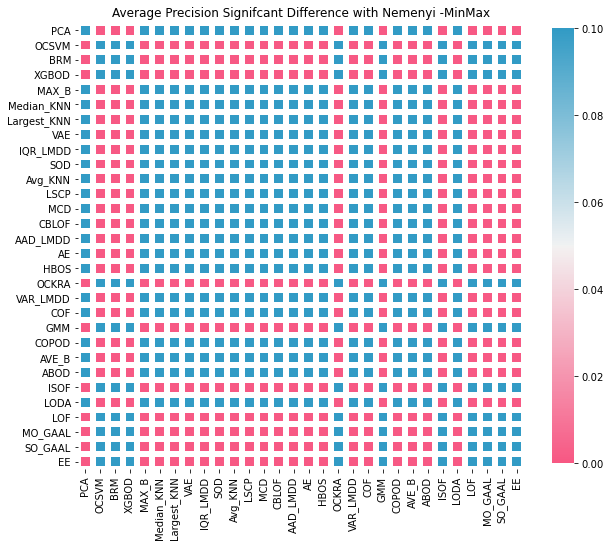

In [44]:
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
ax = sns.heatmap(ny_avg, annot=False, fmt=".1f", 
           linewidths=5, cmap=cmap, vmin=0, vmax=0.1, 
           cbar_kws={"shrink": .8}, square=True)
plt.title('Average Precision Signifcant Difference with Nemenyi -MinMax')

## CD Diagram

In [45]:
def compute_CD_diagram(cd , ranks,metric ,names):
    # Critical difference for Nemenyi test with alpha=0.05.
    graph_ranks(ranks,
    names=names,
    cd=cd,
    width=10,
    textspace=1.5,
    reverse=True)
    title = str(metric) + ' CD Diagram for Nemenyi Test - MinMax'
    plt.title(title)
    plt.show()
    # Critical difference for Bonferroni-Dunn test with alpha=0.05.
    graph_ranks(ranks,
    names=names,
    cd=cd,
    cdmethod=0,
    width=10,
    textspace=1.5,
    reverse=True)
    plt.title(str(metric)  +' CD Diagram for Bonferroni-Dunn Test - MinMax')
    plt.show()

In [46]:
cd_auc1= compute_CD(average_ranks_auc[0:20],
n=len(df_auc.iloc[:,0:20]),
alpha='0.05',
test='nemenyi')

In [47]:
algorithms_names_auc = [i.rstrip('_mm_auc') for i in algorithms_names_auc]

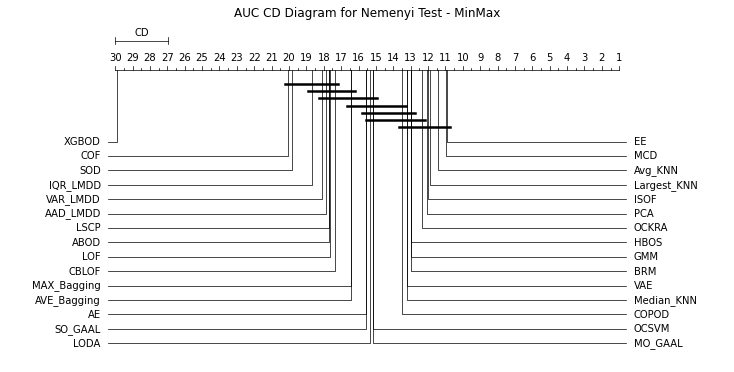

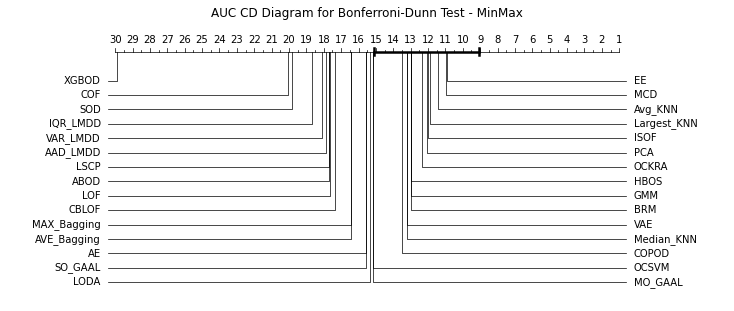

In [48]:
compute_CD_diagram(cd_auc1,average_ranks_auc, 'AUC', algorithms_names_auc)

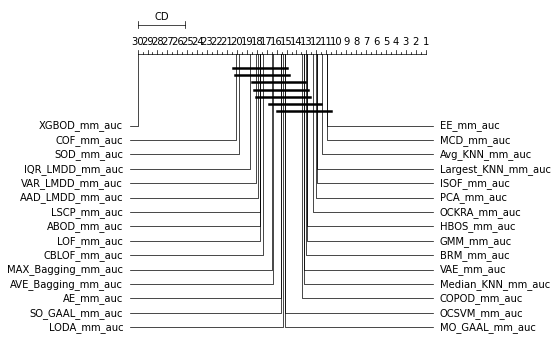

In [49]:
plot_stats(result_auc)
plt.show()

In [50]:
algorithms_names_avg  = [i[:-16] for i in algorithms_names_avg]

In [51]:
cd_avg1= compute_CD(average_ranks_avg_precision[0:20],
n=len(df_avg_precision.iloc[:,0:20]),
alpha='0.05',
test='nemenyi')

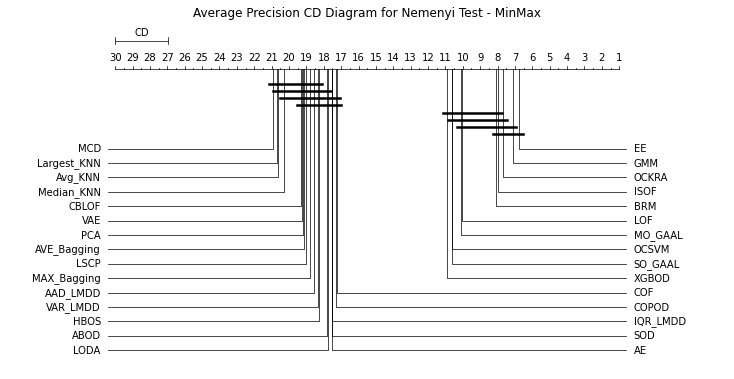

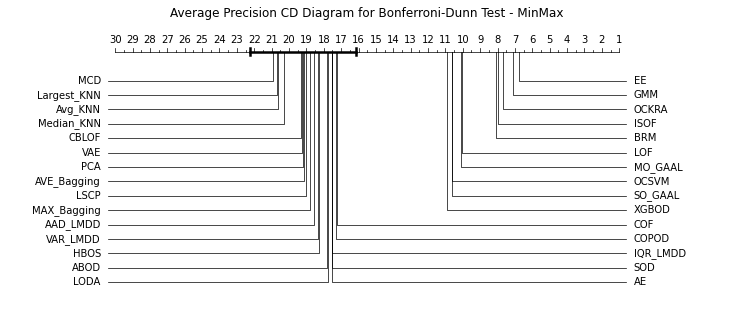

In [52]:
compute_CD_diagram(cd_avg1,average_ranks_avg_precision, 'Average Precision', algorithms_names_avg)

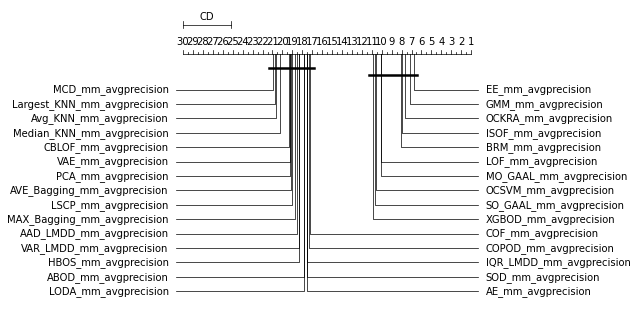

In [53]:
plot_stats(result_avg)
plt.show()

## 2D Diagram|

In [54]:
#pip install adjustText

In [55]:
import random
from adjustText import adjust_text
def plot_2d(df, title = "One-Class Classifiers' Rank - MinMax"):
    # Create layer for 2D Graph
    fig = plt.figure(figsize = (20,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Average Ranking for AUC', fontsize = 15)
    ax.set_ylabel('Averange Ranking for Average Precision', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    # Plot
    targets = df['algorithm'].unique()
    x=np.linspace(0,int(np.max(df.average_precision) +2))
    line = ax.plot(x,x,'g-') # identity line
    ax = sns.scatterplot(x = 'auc', y = 'average_precision' , hue = 'algorithm', data = df, s= 1000, alpha = 0.5, palette = 'muted')
    # zip joins x and y coordinates in pairs
    xs = df['auc']
    ys = df['average_precision']

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(frameon=True, fontsize = 10)
    texts = [plt.text(xs[i], ys[i], '%s' %targets[i], ha='center', va='center' , fontsize = 12) for i in range(len(xs))]
    adjust_text(texts)
    plt.show()

    return None

In [56]:
df_ranking_avg_auc.index  = [i.rstrip('_mm_auc') for i in df_ranking_avg_auc.index ]
df_ranking_avg_avgprecision.index  = [i[:-16] for i in df_ranking_avg_avgprecision.index ]
df_rank_avg = pd.concat([df_ranking_avg_auc, df_ranking_avg_avgprecision], axis = 1)

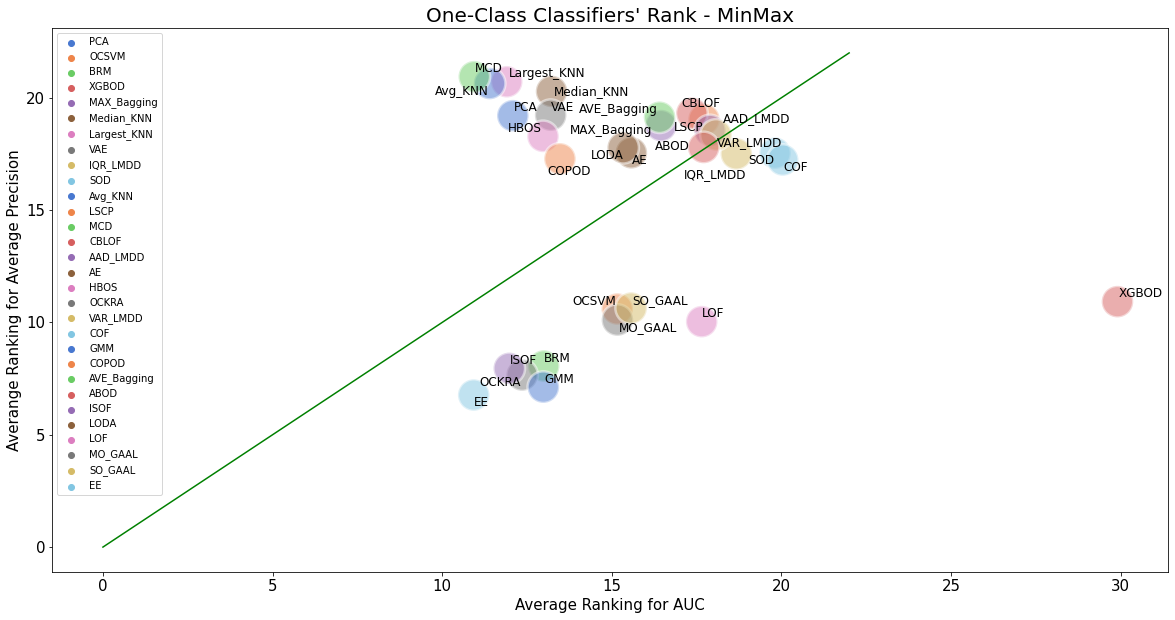

In [57]:
plot_2d(df_rank_avg.reset_index().rename(columns={'index':'algorithm'}))